In [ ]:
import os
from flask import Flask, jsonify
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyspark.sql.functions import countDistinct
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import requests

# Create a Spark session
spark = SparkSession.builder.appName("Cardio Disease Risk").getOrCreate()

In [ ]:
from pyspark import SparkFiles

url = "https://raw.githubusercontent.com/vokouns/Cardiovascular-Diseases-Risk-Prediction/refs/heads/main/data/CVD_cleaned.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("CVD_cleaned.csv"), sep=",", header=True)
df.head()

Row(General_Health='Poor', Checkup='Within the past 2 years', Exercise='No', Heart_Disease='No', Skin_Cancer='No', Other_Cancer='No', Depression='No', Diabetes='No', Arthritis='Yes', Sex='Female', Age_Category='70-74', Height_(cm)='150.0', Weight_(kg)='32.66', BMI='14.54', Smoking_History='Yes', Alcohol_Consumption='0.0', Fruit_Consumption='30.0', Green_Vegetables_Consumption='16.0', FriedPotato_Consumption='12.0')

In [ ]:
# Drop the 'Checkup' column
df = df.drop('Checkup')

# Display the first few rows of the modified DataFrame
df.show()


+--------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|   Sex|Age_Category|Height_(cm)|Weight_(kg)|  BMI|Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|          Poor|      No|           No|         No|          No|        No|      No|      Yes|Female|       70-74|      150.0|      32.66|14.54|            Yes|                0.0|             30.0|                        16.0|                 

In [ ]:
# Check the DataFrame data types
df.dtypes

# Convert Spark DataFrame to Pandas DataFrame
heart_df = df.toPandas()

# Display the Pandas DataFrame
heart_df.head()

,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [ ]:
# Transform the Catagorical data column using get_dummies()
health_dummies_df = pd.get_dummies(heart_df[["General_Health", "Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age_Category", "Smoking_History"]], dtype=int)

# Display sample data
health_dummies_df

,General_Health_Excellent,General_Health_Fair,General_Health_Good,General_Health_Poor,General_Health_Very Good,Exercise_No,Exercise_Yes,Heart_Disease_No,Heart_Disease_Yes,Skin_Cancer_No,...,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_No,Smoking_History_Yes
0,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
4,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
308850,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,1,0
308851,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
308852,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Scaling the numeric columns
health_data_scaled = StandardScaler().fit_transform(heart_df[["Height_(cm)", "Weight_(kg)", "BMI", "Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"]])

# Creating a DataFrame with the scaled data
health_transformed_df = pd.DataFrame(health_data_scaled, columns=["Height_(cm)", "Weight_(kg)", "BMI", "Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"])

# Display data
health_transformed_df

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,-1.934250,-2.386180,-2.159696,-0.621527,0.006625,0.059597,0.664502
1,-0.526857,-0.303547,-0.051548,-0.621527,0.006625,-1.012342,-0.267579
2,-0.714510,0.227770,0.742649,-0.133707,-0.716973,-0.811354,1.130543
3,0.880535,0.461569,0.015913,-0.621527,0.006625,0.997544,0.198462
4,1.912623,0.227770,-0.652562,-0.621527,-0.877772,-0.744358,-0.733620
...,...,...,...,...,...,...,...
308849,-0.245379,-0.090833,0.064975,-0.133707,0.006625,-0.476373,-0.733620
308850,0.880535,-0.643702,-1.095656,0.354113,-0.596373,3.007431,-0.267579
308851,-1.277466,-1.047579,-0.603499,-0.133707,0.408624,-0.476373,-0.267579
308852,1.162014,-0.197190,-0.750686,-0.255662,0.006625,-0.208388,-0.733620


In [ ]:
# Concatenate the scaled and the dummies DataFrames
df_transformed = pd.concat([health_transformed_df, health_dummies_df], axis=1)

# Display sample data
df_transformed.head()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health_Excellent,General_Health_Fair,General_Health_Good,...,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_No,Smoking_History_Yes
0,-1.934250,-2.386180,-2.159696,-0.621527,0.006625,0.059597,0.664502,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,-0.526857,-0.303547,-0.051548,-0.621527,0.006625,-1.012342,-0.267579,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,-0.714510,0.227770,0.742649,-0.133707,-0.716973,-0.811354,1.130543,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.880535,0.461569,0.015913,-0.621527,0.006625,0.997544,0.198462,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1.912623,0.227770,-0.652562,-0.621527,-0.877772,-0.744358,-0.733620,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Determine the number of unique values in each column.
for column in df_transformed.columns:
    # Use nunique() method from pandas to get the number of unique values
    num_unique = df_transformed[column].nunique()
    print(f"Column '{column}' has {num_unique} unique values.")

Column 'Height_(cm)' has 99 unique values.
Column 'Weight_(kg)' has 525 unique values.
Column 'BMI' has 3654 unique values.
Column 'Alcohol_Consumption' has 31 unique values.
Column 'Fruit_Consumption' has 77 unique values.
Column 'Green_Vegetables_Consumption' has 75 unique values.
Column 'FriedPotato_Consumption' has 69 unique values.
Column 'General_Health_Excellent' has 2 unique values.
Column 'General_Health_Fair' has 2 unique values.
Column 'General_Health_Good' has 2 unique values.
Column 'General_Health_Poor' has 2 unique values.
Column 'General_Health_Very Good' has 2 unique values.
Column 'Exercise_No' has 2 unique values.
Column 'Exercise_Yes' has 2 unique values.
Column 'Heart_Disease_No' has 2 unique values.
Column 'Heart_Disease_Yes' has 2 unique values.
Column 'Skin_Cancer_No' has 2 unique values.
Column 'Skin_Cancer_Yes' has 2 unique values.
Column 'Other_Cancer_No' has 2 unique values.
Column 'Other_Cancer_Yes' has 2 unique values.
Column 'Depression_No' has 2 unique v

We removed the transformed dataframe correlation matrix heatmap  to allow for more space in the optimization.

In [43]:
# Import our dependencies
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [44]:
# Split our preprocessed data into our features and target arrays
# X should include all features EXCEPT the target variables
# y should be the target variable
X = df_transformed.drop(["Heart_Disease_Yes","Heart_Disease_No"],axis=1).values
y = df_transformed["Heart_Disease_Yes"].values

# Split the data into a training and testing dataset. We changed the test size ration and random state from the origial model.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [45]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer. We reduced the number of layers and changed
# the number of hidden nodes in our optimization.
input_features = len(X_train[0])
hidden_nodes_layer1 = 16
hidden_nodes_layer2 = 3


nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=input_features))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759 (2.96 KB)

 Trainable params: 759 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [48]:
# Train the model - we reduced the number of epochs from our original model due to high accuracy scores.
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9127 - loss: 0.2589
Epoch 2/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9189 - loss: 0.2231
Epoch 3/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9200 - loss: 0.2199
Epoch 4/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9200 - loss: 0.2205
Epoch 5/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9196 - loss: 0.2208
Epoch 6/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9202 - loss: 0.2195
Epoch 7/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9195 - loss: 0.2213
Epoch 8/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9202 - loss: 0.2195
Epoch 9/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9198 - loss: 0.2195
Epoch 10/10
8687/8687 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9197 - loss: 0.2203


In [49]:
# Save the Keras model as an .h5 file - we temporarly used this model for our prediction site while we optimized and found the best model.
nn_model.save('nn_model.keras')

In [50]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

966/966 - 1s - 1ms/step - accuracy: 0.9192 - loss: 0.2208
Loss: 0.22079609334468842, Accuracy: 0.9191542863845825


In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Making predictions using the testing data
predictions = nn_model.predict(X_test_scaled)

# Convert predictions to binary class labels using a threshold - lowered the threshold in the optimization
predictions = (predictions > 0.6).astype(int)

966/966 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [52]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [53]:
# Displaying results
print("Confusion Matrix")
display(cm_df)

print("Classification Report")
print(classification_report(y_test, predictions,
                            target_names=["No Heart Disease", "Heart Disease"]))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,28357,32
Actual 1,2463,34


Classification Report
                  precision    recall  f1-score   support

No Heart Disease       0.92      1.00      0.96     28389
   Heart Disease       0.52      0.01      0.03      2497

        accuracy                           0.92     30886
       macro avg       0.72      0.51      0.49     30886
    weighted avg       0.89      0.92      0.88     30886



In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

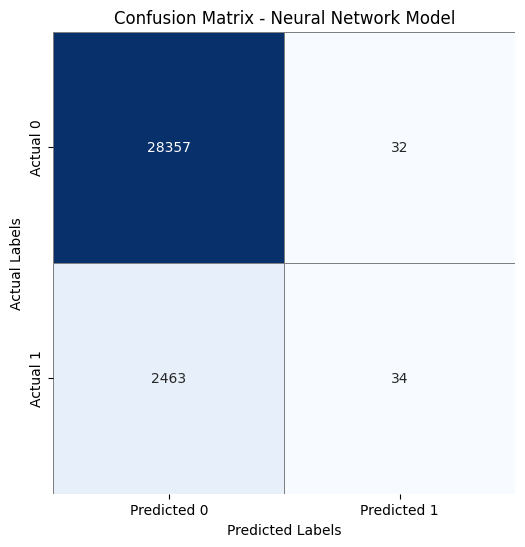

<Figure size 640x480 with 0 Axes>

In [55]:
# NN model confusion matrix vizualization graph

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='gray')
plt.title("Confusion Matrix - Neural Network Model")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

plt.savefig("nn_matrix.png")

In [ ]:
# Alternative model two - Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Copy original dataframe
random_df = df_transformed.copy()

# Define features set
X = random_df.drop(["Heart_Disease_Yes","Heart_Disease_No"],axis=1)

# Define target vector
y = random_df["Heart_Disease_Yes"].values.reshape(-1, 1)

# Splitting into Train and Test sets - changed the test size to account for data sizing issues
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=72)

# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=72)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Calculating the confusion matrix
rfcm = confusion_matrix(y_test, predictions)
rfcm_df = pd.DataFrame(
    rfcm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [ ]:
# Displaying results - precision scores for predicting heart disease are lower than nn model.
print("Confusion Matrix")
display(rfcm_df)

print("Classification Report")
print(classification_report(y_test, predictions,
                            target_names=["No Heart Disease", "Heart Disease"]))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,28276,179
Actual 1,2309,122


Classification Report
                  precision    recall  f1-score   support

No Heart Disease       0.92      0.99      0.96     28455
   Heart Disease       0.41      0.05      0.09      2431

        accuracy                           0.92     30886
       macro avg       0.66      0.52      0.52     30886
    weighted avg       0.88      0.92      0.89     30886



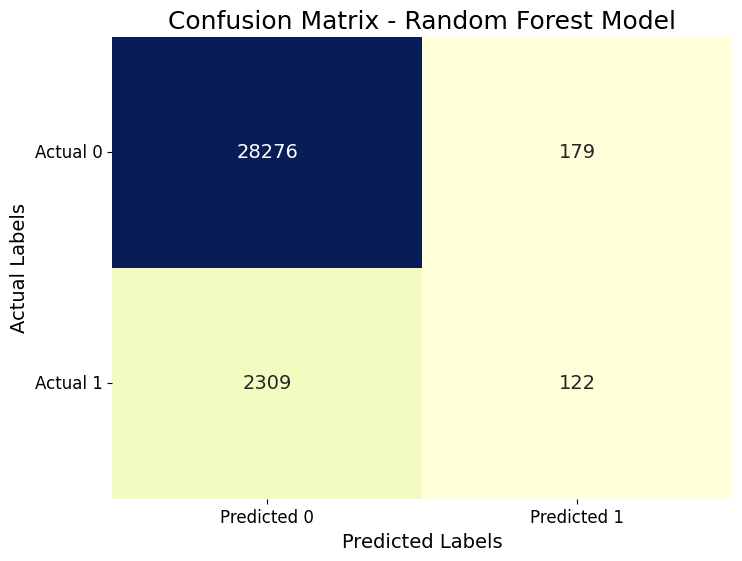

In [ ]:
# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rfcm_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix - Random Forest Model", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("Actual Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

In [ ]:
#Importing the logistic regression model depedencies
from sklearn.linear_model import LogisticRegression

In [ ]:
# Copying the original dataframe for the third model test - logistic regression
regression_df = df_transformed.copy()
regression_df

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health_Excellent,General_Health_Fair,General_Health_Good,...,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_No,Smoking_History_Yes
0,-1.934250,-2.386180,-2.159696,-0.621527,0.006625,0.059597,0.664502,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,-0.526857,-0.303547,-0.051548,-0.621527,0.006625,-1.012342,-0.267579,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,-0.714510,0.227770,0.742649,-0.133707,-0.716973,-0.811354,1.130543,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.880535,0.461569,0.015913,-0.621527,0.006625,0.997544,0.198462,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1.912623,0.227770,-0.652562,-0.621527,-0.877772,-0.744358,-0.733620,0,0,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,-0.245379,-0.090833,0.064975,-0.133707,0.006625,-0.476373,-0.733620,0,0,0,...,0,0,0,0,0,0,0,0,1,0
308850,0.880535,-0.643702,-1.095656,0.354113,-0.596373,3.007431,-0.267579,0,1,0,...,0,0,0,0,1,0,0,0,1,0
308851,-1.277466,-1.047579,-0.603499,-0.133707,0.408624,-0.476373,-0.267579,0,0,0,...,0,0,0,0,0,0,0,0,0,1
308852,1.162014,-0.197190,-0.750686,-0.255662,0.006625,-0.208388,-0.733620,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Define target vector
y = regression_df["Heart_Disease_Yes"]

# Define features set
X = regression_df.drop(["Heart_Disease_Yes","Heart_Disease_No"],axis=1)


In [ ]:
# Split the data into training and testing data.
# Assign a random_state of 72 to the function and changed the test size to account for data sizing issues.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1, random_state=72,
                                                    stratify=y)
X_train.shape


(277968, 43)

In [ ]:
# Initiate the logistic regression classifier
# Assign a random_state parameter of 72 to the model

classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=72)
classifier

LogisticRegression(max_iter=200, random_state=72)

In [ ]:
# Fit the classifier
classifier.fit(X_train, y_train)

# Get the training and testing data scores
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9193252460714902
Testing Data Score: 0.9200932461309331


In [ ]:
# Make predictions using testing data
predictions = classifier.predict(X_test)

results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
# Calculating the confusion matrix
regcm = confusion_matrix(y_test, predictions)
regcm_df = pd.DataFrame(
    regcm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [ ]:
# Displaying results - the logistic regression model shows the highest precision scores for predicting heart disease
print("Confusion Matrix")
display(regcm_df)

target_names = ["No Heart Disease", "Yes Heart Disease"]
print("Classification Report")
print(classification_report(y_test, predictions, target_names=target_names))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,28250,139
Actual 1,2329,168


Classification Report
                   precision    recall  f1-score   support

 No Heart Disease       0.92      1.00      0.96     28389
Yes Heart Disease       0.55      0.07      0.12      2497

         accuracy                           0.92     30886
        macro avg       0.74      0.53      0.54     30886
     weighted avg       0.89      0.92      0.89     30886



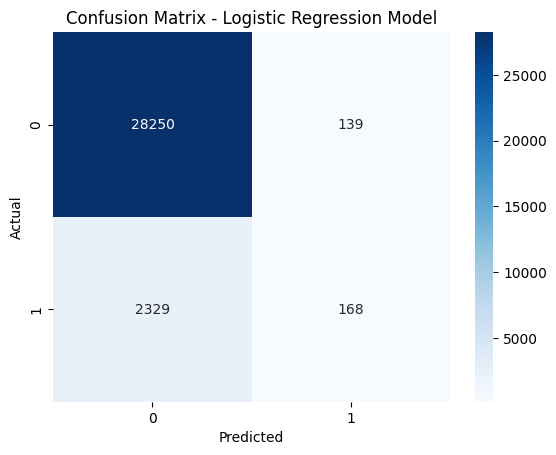

<Figure size 640x480 with 0 Axes>

In [ ]:
# Creating the confusion matrix heatmap
sns.heatmap(regcm, annot=True, fmt="d", cmap="Blues", xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

plt.savefig("regression_matrix.png")

In [ ]:
# Importing our model to test it
import joblib

joblib.dump(classifier, "regression_model.pkl")

model_path = 'regression_model.pkl'

In [ ]:
model = joblib.load('regression_model.pkl')

In [ ]:
# Testing our model

model.predict([[122, 55, 14, 12, 12,12,12, 1,0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0])

In [ ]:
# Saving the regression model to use on our site since it shows the best results out of all of the model optimizations.
joblib.dump(classifier, 'regression_model.pkl')

# Save the scaler object
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved as {scaler_filename}")

# Save the list of columns (used for dummies)
columns = X.columns.tolist()  # Replace with your final training DataFrame
column_list_filename = "column_list.pkl"
joblib.dump(columns, column_list_filename)
print(f"Column list saved as {column_list_filename}")


Scaler saved as scaler.pkl
Column list saved as column_list.pkl


In [ ]:
# Load the current column list
columns = joblib.load("column_list.pkl")

# Remove target columns
columns = [col for col in columns if col not in ["Heart_Disease_Yes", "Heart_Disease_No"]]

# Save the updated column list
joblib.dump(columns, "updated_column_list.pkl")


['updated_column_list.pkl']

In [ ]:
# Verifing our columnns for the site creation
X.columns

Index(['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption',
       'FriedPotato_Consumption', 'General_Health_Excellent',
       'General_Health_Fair', 'General_Health_Good', 'General_Health_Poor',
       'General_Health_Very Good', 'Exercise_No', 'Exercise_Yes',
       'Skin_Cancer_No', 'Skin_Cancer_Yes', 'Other_Cancer_No',
       'Other_Cancer_Yes', 'Depression_No', 'Depression_Yes', 'Diabetes_No',
       'Diabetes_No, pre-diabetes or borderline diabetes', 'Diabetes_Yes',
       'Diabetes_Yes, but female told only during pregnancy', 'Arthritis_No',
       'Arthritis_Yes', 'Sex_Female', 'Sex_Male', 'Age_Category_18-24',
       'Age_Category_25-29', 'Age_Category_30-34', 'Age_Category_35-39',
       'Age_Category_40-44', 'Age_Category_45-49', 'Age_Category_50-54',
       'Age_Category_55-59', 'Age_Category_60-64', 'Age_Category_65-69',
       'Age_Category_70-74', 'Age_Category_75-79', 'Age_Category_80+',
       'Smokin